In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense

# Generate synthetic data
def generate_synthetic_data(timesteps):
    np.random.seed(42)
    time = np.arange(timesteps)
    data = np.sin(0.012 * time) + 0.29 * np.random.randn(timesteps)
    return data

In [35]:
# Prepare the dataset
timesteps = 1000
data = generate_synthetic_data(timesteps)
df = pd.DataFrame(data, columns=['value'])

# Plot the data
# plt.plot(df['value'])
# plt.title('Time Series Data')
# plt.show()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [36]:
def create_dataset(data: np.ndarray, other_columns: list[np.ndarray] = None, time_step: int=10):
    feature_number = 1+len(other_columns) if other_columns else 1
    Y = []
    X = np.full((len(range(time_step, len(data) - 1)), time_step, feature_number), np.nan, dtype=float)
    for i in range(time_step, len(data) - 1):

        window = data[i - time_step : i, 0].reshape(time_step, 1)

        X[i - time_step, :, 0] = window.flatten()

        if other_columns:
          for index, columns in enumerate(other_columns):
              X[i - time_step, :, index+2] = columns[i - time_step : i, 0].reshape(time_step, 1)

        Y.append(data[i, 0])
    return X, np.array(Y, dtype=float).reshape(-1, 1), feature_number, time_step


X, Y, feature_number, time_step = create_dataset(scaled_data)

print(type(X), type(Y), sep=' ')
print(X.shape, Y.shape)
print(f"X:\n{X[:1, :]=}\nY:\n{Y[:1]=}")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(989, 10, 1) (989, 1)
X:
X[:1, :]=array([[[0.5237037 ],
        [0.47252964],
        [0.54385306],
        [0.62288161],
        [0.47495957],
        [0.47852306],
        [0.63841084],
        [0.57198415],
        [0.46890347],
        [0.55969935]]])
Y:
Y[:1]=array([[0.47651847]])


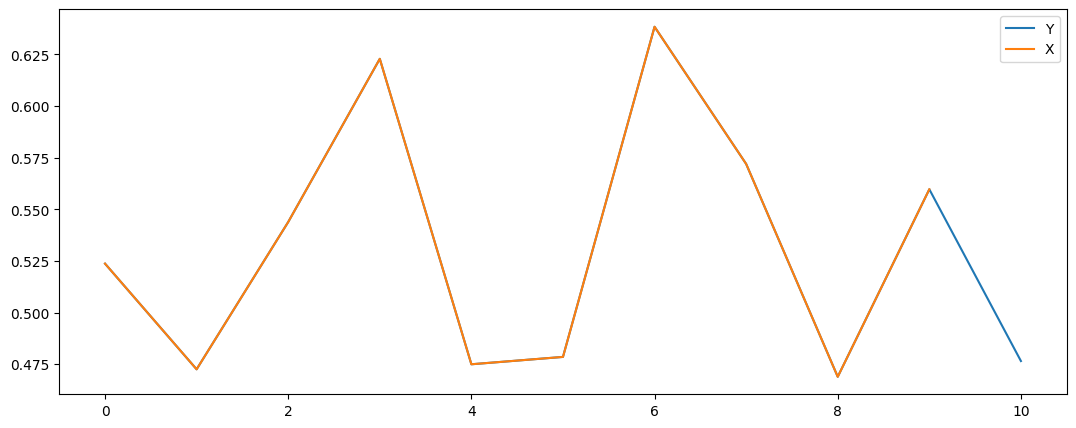

In [37]:
# Plot X and Y
for i in range(1):
  plot_X, plot_all = [], []
  for value in range(X.shape[1]):
    plot_X.append(X[i, value, 0])
    plot_all.append(X[i, value, 0])
  plot_all.append(Y[i, 0])

  plt.figure(figsize=(13, 5))
  plt.plot(plot_all, label='Y')
  plt.plot(plot_X, label='X')
  plt.legend()
  plt.show()

In [38]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(692, 10, 1) (692, 1)
(297, 10, 1) (297, 1)


In [39]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], feature_number)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=1, verbose=1)

Epoch 1/50
692/692 [==============================] - 11s 11ms/step - loss: 0.0131 - val_loss: 0.0091
Epoch 2/50
692/692 [==============================] - 8s 11ms/step - loss: 0.0113 - val_loss: 0.0086
Epoch 3/50
692/692 [==============================] - 8s 11ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 4/50
692/692 [==============================] - 7s 10ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 5/50
692/692 [==============================] - 8s 11ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 6/50
692/692 [==============================] - 7s 10ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 7/50
692/692 [==============================] - 8s 12ms/step - loss: 0.0093 - val_loss: 0.0078
Epoch 8/50
692/692 [==============================] - 7s 10ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 9/50
692/692 [==============================] - 8s 12ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 10/50
692/692 [==============================] - 7s 10ms/step - loss: 0.0093 - val_l

dict_keys(['loss', 'val_loss'])


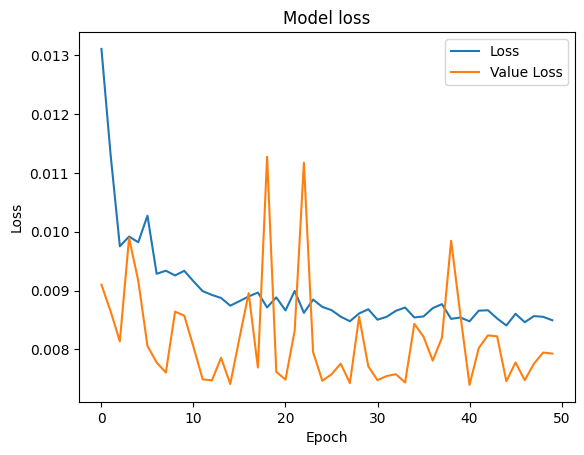

In [41]:
# Plot training & validation loss values
print(history.history.keys())
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Value Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [42]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

10/10 [==============================] - 0s 4ms/step


In [43]:
print(Y_train.shape, train_predict.shape, Y_test.shape, train_predict[:2], test_predict[:2])

(692, 1) (692, 1) (297, 1) [[0.55262935]
 [0.5485562 ]] [[0.7415825]
 [0.7449925]]


In [44]:
# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

In [45]:
# Calculate MSE
train_mse = mean_squared_error(Y_train, train_predict)
test_mse = mean_squared_error(Y_test, test_predict)

# Calculate R2 score
train_r2 = r2_score(Y_train, train_predict)
test_r2 = r2_score(Y_test, test_predict)

print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}")

Train MSE: 0.0901, Test MSE: 0.0897
Train R2 Score: 0.8452, Test R2 Score: 0.7755


len(train_predict)=692, time_step=10, len(scaled_data)=1000, len(X)=989, (len(train_predict) + time_step)=702
test_predict.shape=(297, 1), train_predict.shape=(692, 1), scaled_data.shape=(1000, 1)


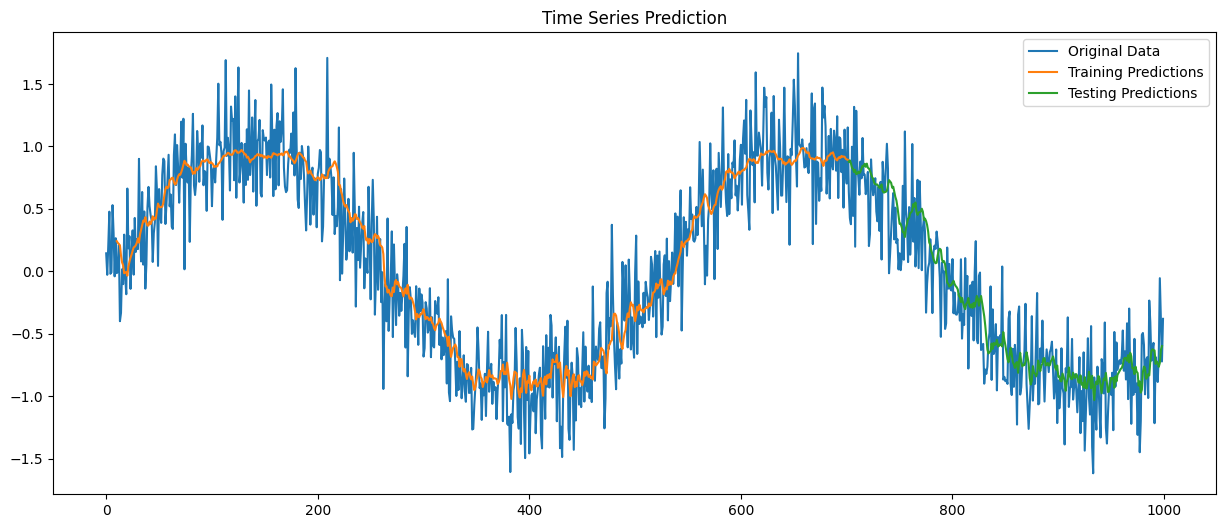

In [46]:
# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Training Predictions')

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
print(f"{len(train_predict)=}, {time_step=}, {len(scaled_data)=}, {len(X)=}, {(len(train_predict) + time_step)=}")
print(f"{test_predict.shape=}, {train_predict.shape=}, {scaled_data.shape=}")
test_predict_plot[len(train_predict) + time_step:len(scaled_data) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Testing Predictions')

plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [47]:
model.save('lstm_model_test.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
# # Load the saved model
# loaded_model = load_model('lstm_model.h5')

In [49]:
# # Assuming `X_new` and `Y_new` are new data arrays
# history_updated = loaded_model.fit(X_new, Y_new, epochs=50, batch_size=1, verbose=1)

# # Save the updated model
# loaded_model.save('updated_lstm_model.h5')